In [1]:
import random

import tqdm
import umap
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
from sklearn import decomposition  # Algoritmos de reduccion de dimensionalidad.

# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

random_state = 42

%matplotlib inline


## 1. Métodos de *clustering*

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [11]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=random_state)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=random_state)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=random_state)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

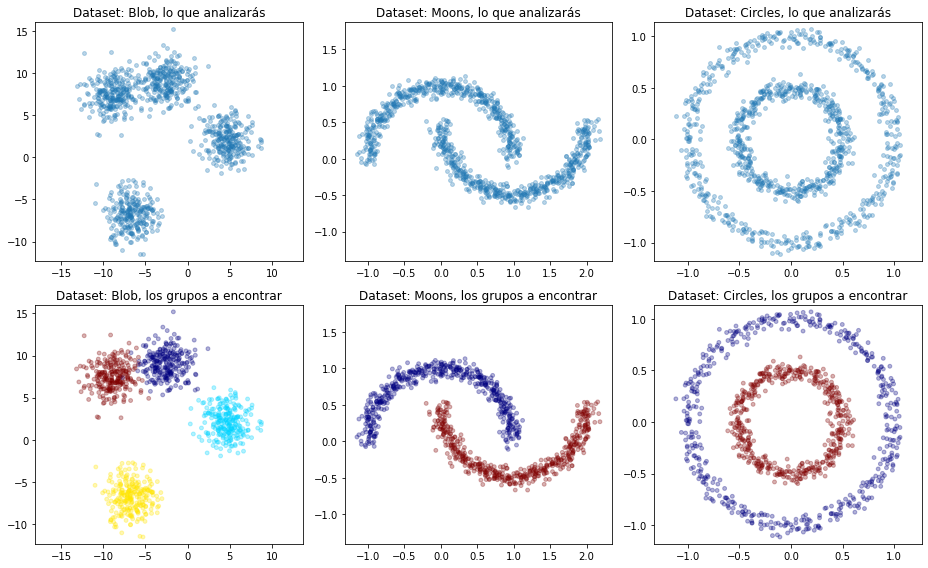

In [12]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [18]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

A continuación, se crea una función que calcula el `SSE`:

In [19]:
def sse_c(x, kmeans):
    sse = 0
    for point, center in list(zip(x,kmeans.cluster_centers_[kmeans.labels_])):
        sse += np.square(point - center).sum()
    return sse

In [20]:
from sklearn.cluster import KMeans

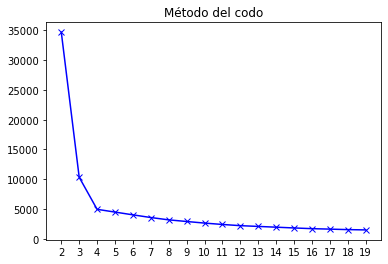

In [21]:
ks = range(2, 20)
sses = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=400).fit(X)
    sses.append(sse_c(X, kmeans))
    
plt.plot(ks, sses, 'bx-')
plt.title('Método del codo')
plt.xticks(ks)
plt.show()

El método del codo consiste en iterar el mismo conjunto de datos para distintos valores del número de clústers, y por inspección gráfica se seleccionará el valor que se encuentra en el “codo” de la curva. Para esto, utilizamos la función `sse_c` que calcula `𝑆𝑆𝐸` de cada valor de `k`.

Por observación, el número óptimo de clústers en el dataset blobs es 4, donde la curva comienza a estabilizarse.

***¿Cómo podría mejorarse la elección de  𝑘 ?***

Podemos calcular el coeficiente de silhouette que proporciona un valor entre -1.0 y 1.0, he indica lo bien o mal que se está agrupando un punto en su clúster. Los valores cercanos a 1.0 indican que el punto está en el grupo correcto. Los valores cercanos a -1.0 indican que el punto está en el grupo incorrecto.

Esta medida se calcula para cada punto $xi$ del conjunto de datos, como se muestra a continuación:

$$
S(X_i) = \frac{b(x_i) - a(x_1)}{max(a(x_i), b(x_i))}
$$

donde: $a(xi)$ es la distancia promedio de una muestra a todas las de su mismo grupo. $b(xi)$ es la distancia mínima de la muestra a cualquirt otra muestra del resto del grupo.

Por último, se calcular el promedio de los coeficientes de Silhouette de todas las muestras del conjunto de datos (SC), como se muestra a continuación:

$$
SC = \frac{1}{N} \sum_{i_1}^n S(X_i)
$$

En python podemos utilizar la función `silhouette_score` de la libraría `sklearn.metrics`.

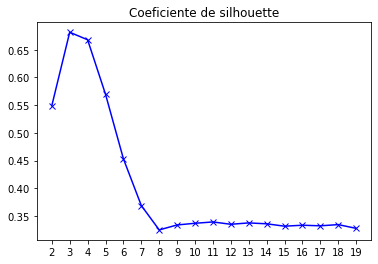

In [22]:
from sklearn.metrics import silhouette_score

ks = range(2, 20)
sc = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=400).fit(X)
    sc.append(silhouette_score(X, kmeans.labels_))
    
plt.plot(ks, sc, 'bx-')
plt.title('Coeficiente de silhouette')
plt.xticks(ks)
plt.show()

In [23]:
# k óptimo utilizando el coeficiente de silhouette
ks[np.argmax(sc)]

3

Con el coeficiente de silhouette, el número óptimo de k es 3.

Para probar que si el método del codo o el coeficiente de silhouette han agrupado los clústers correctamente, se compararán gráficamente los $k$ óptimos de ambos métodos.

In [24]:
kmeans_elbow = KMeans(n_clusters=4, random_state=random_state, max_iter=400).fit(X)
kmeans_silh = KMeans(n_clusters=3,random_state=random_state, max_iter=400).fit(X)

Para probar que la función `sse_c` calcular el valor correcto de `SSE`, comparamos el valor de la variable `inertia_` del objecto KMeans:

In [26]:
assert(sse_c(X, kmeans_elbow) == kmeans_elbow.inertia_)

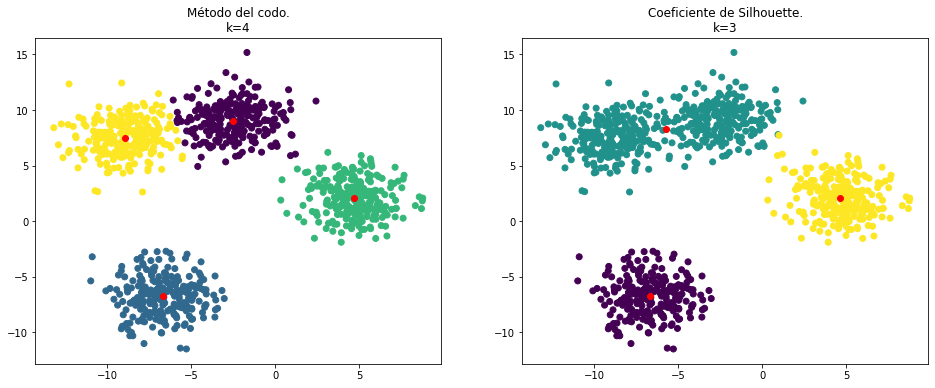

In [27]:
fig, axis = plt.subplots(1, 2, figsize=(16, 6))

axis[0].scatter(X[:,0], X[:,1], c=kmeans_elbow.labels_)
axis[0].scatter(kmeans_elbow.cluster_centers_[:, 0], kmeans_elbow.cluster_centers_[:, 1], color = 'red')
axis[0].set_title('Método del codo.\nk=4')

axis[1].scatter(X[:,0], X[:,1], c=kmeans_silh.labels_)
axis[1].scatter(kmeans_silh.cluster_centers_[:, 0], kmeans_silh.cluster_centers_[:, 1], color = 'red')
axis[1].set_title('Coeficiente de Silhouette.\nk=3')
plt.show()

En el dataset **blobs** existen 4 clústers. Para este ejercicio, se ha utilizado el método del codo y el coeficiente de Silhouette para el calculó de un k óptimo, generando como resultado 4 y 3 respectivamente.

Los datos del dataset **blobs** están agrupados de forma circular, lo que favorece a la creación de clústers utilizando el algoritmo k-means.

In [28]:
X, y = X_moons, y_moons

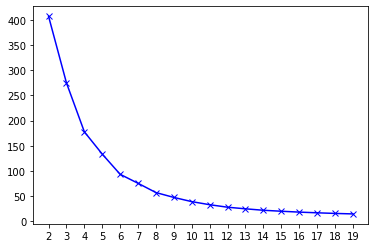

In [29]:
ks = range(2, 20)
sses = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=400).fit(X)
    sses.append(sse_c(X, kmeans))
    
plt.plot(ks, sses, 'bx-')
plt.xticks(ks)
plt.show()

Por observación, el número óptimo de clústers en el dataset **Moons** es 6.

A continuación, se calcula el coeficiente de silhouette:

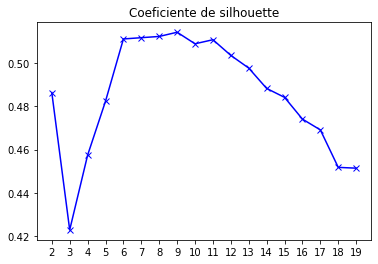

In [30]:
ks = range(2, 20)
sc = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=400).fit(X)
    sc.append(silhouette_score(X, kmeans.labels_))
    
plt.plot(ks, sc, 'bx-')
plt.title('Coeficiente de silhouette')
plt.xticks(ks)
plt.show()

In [31]:
# k óptimo utilizando el coeficiente de silhouette
ks[np.argmax(sc)]

9

El k óptimo obtenido por el coeficiente de silhouette es 9.

In [32]:
kmeans_elbow = KMeans(n_clusters=6,random_state=random_state, max_iter=400).fit(X)
kmeans_silh = KMeans(n_clusters=9,random_state=random_state, max_iter=400).fit(X)
kmeans_two = KMeans(n_clusters=2,random_state=random_state, max_iter=400).fit(X)

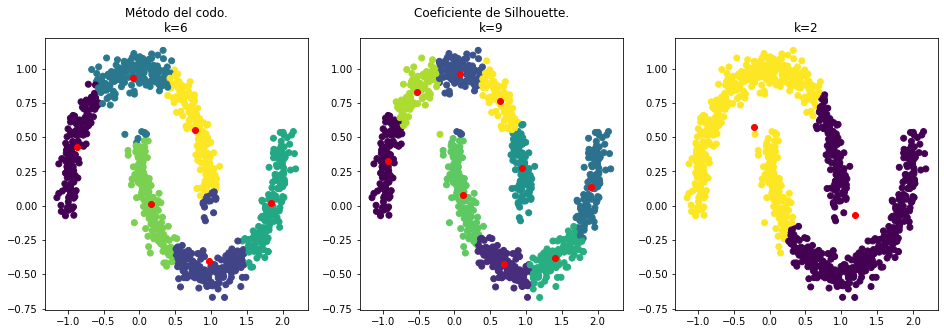

In [33]:
fig, axis = plt.subplots(1, 3, figsize=(16, 5))

axis[0].scatter(X[:,0], X[:,1], c=kmeans_elbow.labels_)
axis[0].scatter(kmeans_elbow.cluster_centers_[:, 0], kmeans_elbow.cluster_centers_[:, 1], color = 'red')
axis[0].set_title('Método del codo.\nk=6')

axis[1].scatter(X[:,0], X[:,1], c=kmeans_silh.labels_)
axis[1].scatter(kmeans_silh.cluster_centers_[:, 0], kmeans_silh.cluster_centers_[:, 1], color = 'red')
axis[1].set_title('Coeficiente de Silhouette.\nk=9')

axis[2].scatter(X[:,0], X[:,1], c=kmeans_two.labels_)
axis[2].scatter(kmeans_two.cluster_centers_[:, 0], kmeans_two.cluster_centers_[:, 1], color = 'red')
axis[2].set_title('k=2')
plt.show()

El dataset **Moons** tiene 2 clústers de forma semi esférica. Para este ejercicio, se ha utilizado el método del codo y el coeficiente de Silhouette para el calculó de un k óptimo, generando como resultado 6 y 9 respectivamente.

La diferencia entre los clústers originales y los clústers formados por K-means, se debe por la tendencia del algoritmo k-means en crear clústers esféricos, lo que dificulta el desarrollo de clústers en el dataset **Moons** debido a que sus datos están densamente agrupados en forma geométrica.  

In [34]:
X, y = X_circles, y_circles

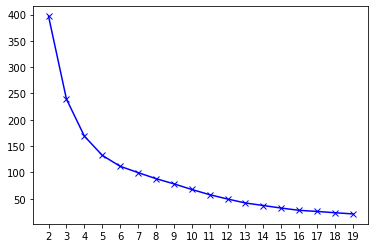

In [35]:
ks = range(2, 20)
sses = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=400).fit(X)
    sses.append(sse_c(X, kmeans))
    
plt.plot(ks, sses, 'bx-')
plt.xticks(ks)
plt.show()

Por observación, el número óptimo de clústers en el dataset **Circles** es 5, donde la curva comienza a estabilizarse.

A continuación, se calcula el coeficiente de silhouette:

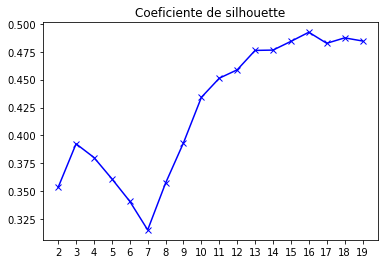

In [36]:
ks = range(2, 20)
sc = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=400).fit(X)
    sc.append(silhouette_score(X, kmeans.labels_))
    
plt.plot(ks, sc, 'bx-')
plt.title('Coeficiente de silhouette')
plt.xticks(ks)
plt.show()

In [37]:
kmeans_elbow = KMeans(n_clusters=5, random_state=random_state, max_iter=400).fit(X)
kmeans_two = KMeans(n_clusters=2,random_state=random_state, max_iter=400).fit(X)

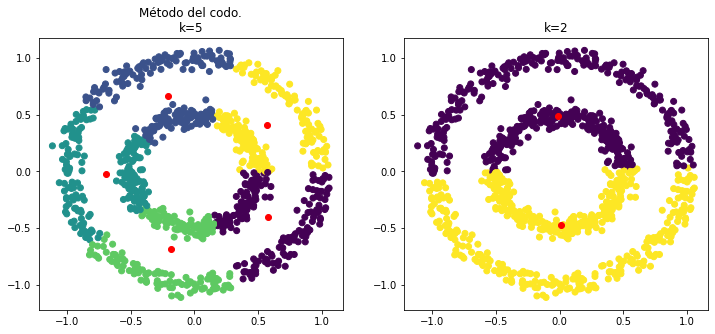

In [38]:
fig, axis = plt.subplots(1, 2, figsize=(12, 5))

axis[0].scatter(X[:,0], X[:,1], c=kmeans_elbow.labels_)
axis[0].scatter(kmeans_elbow.cluster_centers_[:, 0], kmeans_elbow.cluster_centers_[:, 1], color = 'red')
axis[0].set_title('Método del codo.\nk=5')

axis[1].scatter(X[:,0], X[:,1], c=kmeans_two.labels_)
axis[1].scatter(kmeans_two.cluster_centers_[:, 0], kmeans_two.cluster_centers_[:, 1], color = 'red')
axis[1].set_title('k=2')
plt.show()

El dataset **Circles** forma 2 clústers circulares, uno dentro del otro. Para este ejercicio, se ha utilizó el método del codo generando como resultado 5 k óptimos.

La diferencia entre los clústers originales y los clústers formados por K-means, se debe por la tendencia del algoritmo k-means en crear clústers esféricos, lo que dificulta el desarrollo de clústers en el dataset **Circles** debido a que sus datos están densamente agrupados en forma geométrica. 